In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import time
import os

In [2]:
class Network(nn.Module):
    def __init__(self,num_input=2,layers=[128, 128, 128, 128],num_output=4):
        super(Network,self).__init__()
        self.input_layer=nn.Linear(num_input,layers[0])
        self.hidden_layer=nn.ModuleList()
        for i in range(len(layers)-1):
            self.hidden_layer.append(nn.Linear(layers[i],layers[i+1]))
        self.output_layer=nn.Linear(layers[-1],num_output)
    def forward(self,out):
        out=torch.tanh(self.input_layer(out))
        for layer in self.hidden_layer:
            out=torch.tanh(layer(out))
        out=self.output_layer(out)
        return out

In [3]:
class Pinns:
    def __init__(self):
        # Transfer to GPU if it is possible
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network().to(self.device)

        # Physical parameters (dimensionless)
        self.Ra = torch.tensor(1e7, device=self.device)  # Rayleigh number
        self.Pr = torch.tensor(0.7096, device=self.device)  # Prandtl number

        # Domain_Definition
        dx=0.01
        dy=0.01
        self.x=torch.arange(-0.25,0.25+dx,dx)
        self.y=torch.arange(-0.5,0.5+dy,dy)
        self.X = torch.stack(torch.meshgrid(self.x,self.y)).reshape(2,-1).T
        self.X.requires_grad = True

        # Boundary_condition_input
        dx_b=0.0005
        dy_b=0.001
        self.x_b = torch.arange(-0.25,0.25+dx_b,dx_b)
        self.y_b = torch.arange(-0.5,0.5+dy_b,dy_b)
        self.rw = torch.stack(torch.meshgrid(self.x_b[-1],self.y_b)).reshape(2,-1).T
        self.lw = torch.stack(torch.meshgrid(self.x_b[0],self.y_b)).reshape(2,-1).T
        self.uw = torch.stack(torch.meshgrid(self.x_b,self.y_b[-1])).reshape(2,-1).T
        self.dw = torch.stack(torch.meshgrid(self.x_b,self.y_b[0])).reshape(2,-1).T
        self.X_train = torch.cat([self.rw, self.lw, self.uw,  self.dw])
        self.uw.requires_grad = True
        self.dw.requires_grad = True

        # Boundary_condition_output
        self.uv_rw = torch.stack(torch.meshgrid(self.x_b[500],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_lw = torch.stack(torch.meshgrid(self.x_b[500],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_uw = torch.stack(torch.meshgrid(self.x_b[500],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_dw = torch.stack(torch.meshgrid(self.x_b[500],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_train = torch.cat([self.uv_rw, self.uv_lw, self.uv_uw,  self.uv_dw])
        self.T_rw = torch.zeros_like(self.y_b)+1
        self.T_lw = torch.zeros_like(self.y_b)
        self.dT_uw = torch.zeros_like(self.y_b)
        self.dT_dw = torch.zeros_like(self.y_b)
        
        # Transfer tensor to GPU
        self.uv_train = self.uv_train.to(self.device)
        self.X_train = self.X_train.to(self.device)
        self.X = self.X.to(self.device)
        self.T_rw = self.T_rw.to(self.device)
        self.T_lw = self.T_lw.to(self.device)
        self.dT_uw = self.dT_uw.to(self.device)
        self.dT_dw = self.dT_dw.to(self.device)
        self.lw = self.lw.to(self.device)
        self.rw = self.rw.to(self.device)
        self.uw = self.uw.to(self.device)
        self.dw = self.dw.to(self.device)

        # Error criterion Definition
        self.criterion = nn.MSELoss()

        # Optimizer setting
        self.adam = torch.optim.Adam(self.network.parameters(), lr=1e-4)
        # , lr=1e-4
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
        self.network.parameters(),
            lr=0.01,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-8,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        self.loss_history = []
    #compute derivations
    def gradient_b(self, input, inputs):
        output = torch.autograd.grad(
            input,
            inputs,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True
        )[0]
        return output
    def gradient(self,input,index):
        output = torch.autograd.grad(
            input,
            self.X,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True
        )[0]
        return output[:,index]

    def loss_f(self):
        #Restart Optimizer
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        #output of NN for boundary
        self.uv_P_b = self.network(self.X_train)
        self.u_P_b = self.uv_P_b[:,0]
        self.v_P_b = self.uv_P_b[:,1]
        self.theta_P_l =  self.network(self.lw)[:,3]
        self.theta_P_r =  self.network(self.rw)[:,3]
        self.theta_P_u =  self.network(self.uw)[:,3]
        self.theta_P_d =  self.network(self.dw)[:,3]
        self.dtheta_P_b_u_dy = self.gradient_b(self.theta_P_u,self.uw)[:,1]
        self.dtheta_P_b_d_dy = self.gradient_b(self.theta_P_d,self.dw)[:,1]

        #loss data definition
        self.loss_data =(self.criterion(self.u_P_b,self.uv_train[:,0])+self.criterion(self.v_P_b,self.uv_train[:,1])+
                        self.criterion(self.theta_P_l,self.T_lw)+self.criterion(self.theta_P_r,self.T_rw)+
                        self.criterion(self.dtheta_P_b_u_dy,self.dT_uw)+self.criterion(self.dtheta_P_b_d_dy,self.dT_dw)
                        )
        

        #output of NN
        self.uvp_P = self.network(self.X)
        self.u_P = self.uvp_P[:,0]
        self.v_P = self.uvp_P[:,1]
        self.p_P = self.uvp_P[:,2]
        self.theta_P = self.uvp_P[:,3]

        #compute derivations
        self.du_dx = self.gradient(self.u_P,0)
        self.du_dy = self.gradient(self.u_P,1)
        self.du_dxx= self.gradient(self.du_dx,0)
        self.du_dyy= self.gradient(self.du_dy,1)
        self.dv_dx = self.gradient(self.v_P,0)
        self.dv_dy = self.gradient(self.v_P,1)
        self.dv_dxx= self.gradient(self.dv_dx,0)
        self.dv_dyy= self.gradient(self.dv_dy,1)
        self.dp_dx = self.gradient(self.p_P,0)
        self.dp_dy = self.gradient(self.p_P,1)
        self.dtheta_dx = self.gradient(self.theta_P,0)
        self.dtheta_dy = self.gradient(self.theta_P,1)
        self.dtheta_dxx = self.gradient(self.dtheta_dx,0)
        self.dtheta_dyy = self.gradient(self.dtheta_dy,1)
        
        # compute equation loss
        self.con_equ=self.du_dx+self.dv_dy
        self.u_equ = self.uvp_P[:,0]*self.du_dx + self.uvp_P[:,1]*self.du_dy + self.dp_dx - torch.sqrt(self.Pr / self.Ra) *(self.du_dxx + self.du_dyy)
        self.v_equ = self.uvp_P[:,0]*self.dv_dx + self.uvp_P[:,1]*self.dv_dy + self.dp_dy - torch.sqrt(self.Pr / self.Ra) *(self.dv_dxx + self.dv_dyy) - self.uvp_P[:,3]
        self.e_equ = self.uvp_P[:,0] * self.dtheta_dx + self.uvp_P[:,1] * self.dtheta_dy - torch.sqrt(1.0 / (self.Ra * self.Pr)) * (self.dtheta_dxx + self.dtheta_dyy)

        #loss PDE definition
        self.loss_pde = (self.criterion(self.con_equ,torch.zeros_like(self.con_equ))+self.criterion(self.u_equ,torch.zeros_like(self.u_equ))+
                        self.criterion(self.v_equ,torch.zeros_like(self.v_equ))+self.criterion(self.e_equ,torch.zeros_like(self.e_equ))
                        )

        #loss function definition
        lambda_bc = 1.0
        lambda_pde = 1.0
        self.loss = lambda_bc * self.loss_data + lambda_pde * self.loss_pde
        self.loss.backward()
        return self.loss
    def train(self, num_epochs=1):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss_f()
            self.loss_history.append(loss.item())
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {self.loss.item():.8f}")
            if i % 1000 == 0:
                torch.save(self.network.state_dict(), r'C:/Users/hossein/Result/Natural Convection/Ra=10^7/1-PINNs/model')
            self.adam.step(self.loss_f)
        self.optimizer.step(self.loss_f)
        torch.save(self.network.state_dict(), r'C:/Users/hossein/Result/Natural Convection/Ra=10^7/1-PINNs/model')
    def plot(self):
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        self.network.eval()
        with torch.no_grad():
            self.u = self.uvp_P[:,0].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.v = self.uvp_P[:,1].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.T = self.uvp_P[:,3].reshape(len(self.x), len(self.y)).cpu().numpy().T

        plt.rcParams.update({
            "font.family": "Times New Roman",
            "font.style": "italic"
        })

        plt.figure(figsize=(4, 5))
        contour1 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, levels=50, cmap="jet")
        cbar = plt.colorbar(contour1)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))      
        plt.xlabel("X ", fontsize=13)
        plt.ylabel("Y ", fontsize=13)
        plt.title("u velocity", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Natural Convection/Ra=10^7/1-PINNs/u_plot.png", dpi=300)
        plt.show()
        plt.close()

        plt.figure(figsize=(4, 5))
        contour2 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.v, levels=50, cmap="jet")
        cbar = plt.colorbar(contour2)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))
        plt.xlabel("X ", fontsize=13)
        plt.ylabel("Y ", fontsize=13)
        plt.title("v velocity", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Natural Convection/Ra=10^7/1-PINNs/v_plot.png", dpi=300)
        plt.show()
        plt.close()

        plt.figure(figsize=(4, 5))
        contour3 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.T, levels=50, cmap="jet")
        cbar = plt.colorbar(contour3)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))
        plt.xlabel("X", fontsize=13)
        plt.ylabel("Y", fontsize=13)
        plt.title("Pressure", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Natural Convection/Ra=10^7/1-PINNs/Temperature_plot.png", dpi=300)
        plt.show()
        plt.close()

        plt.figure(figsize=(4, 6))
        plt.streamplot(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, self.v, color='red', cmap='autumn', linewidth=0.5, density=2.0, arrowsize=0)
        plt.xlabel("X", fontsize=13)
        plt.ylabel("Y", fontsize=13)
        plt.title("streamline", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Natural Convection/Ra=10^7/1-PINNs/streamline_plot.png", dpi=300)
        plt.show()
        plt.close()

    def plot_loss(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Function History')
        plt.yscale("log")
        plt.grid(True)
        plt.legend()
        plt.show()
        df = pd.DataFrame({"loss": self.loss_history})
        df.to_csv("C:/Users/hossein/Result/Natural Convection/Ra=10^7/1-PINNs/loss_history5.csv", index=False)

C:\Windows\system32\pytorch-env\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 0, Loss: 0.00000982
Iteration 10, Loss: 0.00183798
Iteration 20, Loss: 0.00034980
Iteration 30, Loss: 0.00016298
Iteration 40, Loss: 0.00006834
Iteration 50, Loss: 0.00002153
Iteration 60, Loss: 0.00001388
Iteration 70, Loss: 0.00000981
Iteration 80, Loss: 0.00000784
Iteration 90, Loss: 0.00000746


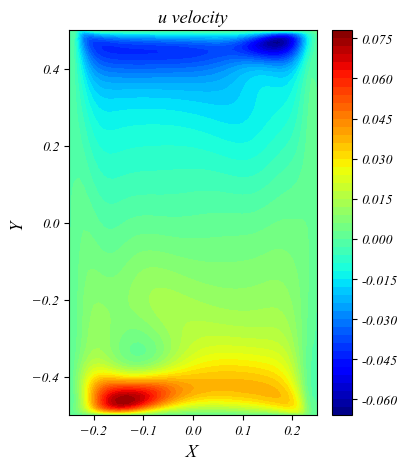

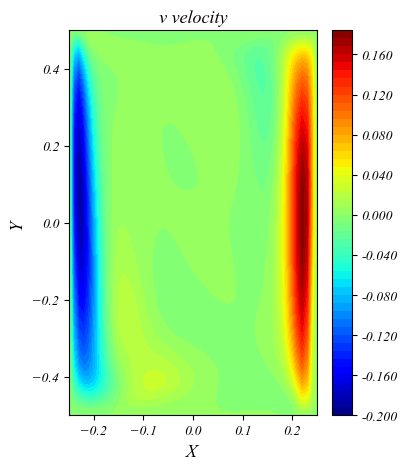

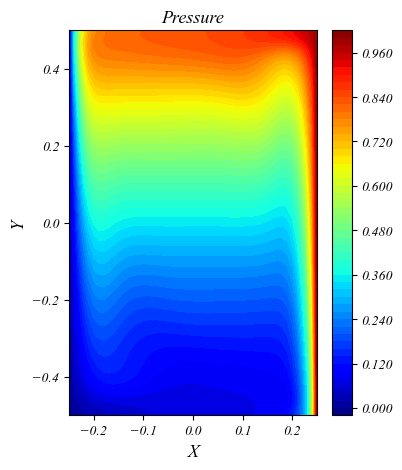

C:\Windows\system32\pytorch-env\lib\site-packages\matplotlib\patches.py:3436: RuntimeWarning: invalid value encountered in scalar divide
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


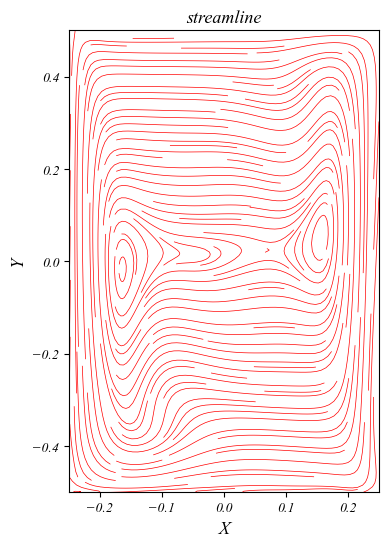

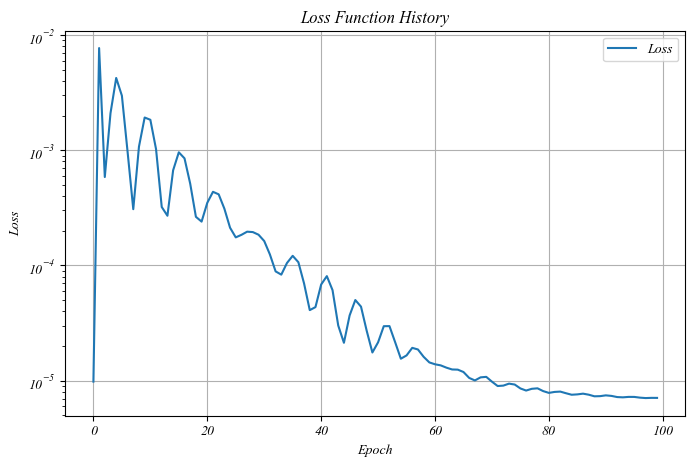

In [4]:
net = Pinns()
net.network.load_state_dict(torch.load(r'C:/Users/hossein/Result/Natural Convection/Ra=10^7/1-PINNs/model'))
net.train(num_epochs=100)
net.plot()
net.plot_loss()